In [1]:
"""
電圧降下の異常検知
パラメーター
移動平均日数：mv0　初期 8
回帰に使用するデータ期間：days　初期 91

"mv0"日移動平均をとり、その移動平均のデータ（最長"days"日）を使って1次回帰
傾きが負且つ電圧が"v_lim"未満になれば異常検知”電圧降下”とする。
一度異常検知すればリセットされるまで同じ警報は出さない。
3.55Vを超えたらリセット
"""

'\n電圧降下の異常検知\nパラメーター\n移動平均日数：mv0\u3000初期 8\n回帰に使用するデータ期間：days\u3000初期 91\n\n"mv0"日移動平均をとり、その移動平均のデータ（最長"days"日）を使って1次回帰\n傾きが負且つ電圧が"v_lim"未満になれば異常検知”電圧降下”とする。\n一度異常検知すればリセットされるまで同じ警報は出さない。\n3.55Vを超えたらリセット\n'

In [2]:
#20201002 野呂
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline
import warnings
import datetime
warnings.filterwarnings('ignore')

In [3]:
#excelの読み込み
v_trend=pd.read_excel("C:/Users/H4869/TR-BRAIN/v_trend.xlsx", sheet_name=0, index_col=None, usecols =3,skiprows=None, encoding="cp932")

#日付をindexにする
#datetime64[ns]型の列をインデックスに指定すると、そのインデックスはDatetimeIndex型となる。
v_trend.set_index(["recordDate"], inplace=True)
v_trend


,Battery,VRMSXAcc
recordDate,,
2020-01-05 00:58:38,3.48,17.716535
2020-01-05 00:59:09,3.48,17.716535
2020-01-05 01:03:47,3.48,17.716535
2020-01-05 01:04:18,3.49,17.322835
2020-01-05 01:08:41,3.49,17.322835
2020-01-05 01:09:38,3.49,17.322835
2020-01-12 02:18:32,3.52,16.535433
2020-01-12 02:23:04,3.52,16.535433
2020-01-12 02:23:35,3.52,16.535433


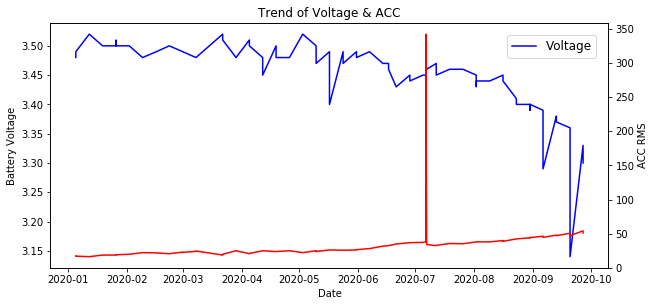

In [4]:
#電圧と加速度のトレンドをプロットして影響を確認

plt.figure(figsize=(10,5)).autofmt_xdate()
plt.subplot().plot(v_trend["Battery"],color="b",label="Voltage")
plt.title("Trend of Voltage & ACC")
plt.xlabel("Date")
plt.ylabel("Battery Voltage")
plt.legend(bbox_to_anchor=(1, 1), loc='upper right', borderaxespad=1, fontsize=12)

acc_trend = plt.subplot().twinx() # 第二軸
acc_trend.plot(v_trend["VRMSXAcc"],color="r", label="ACC RMS")
plt.ylabel("ACC RMS")

plt.show()
#savefig(prms, "Trend of Voltage & ACC") #TR-BRAINに表示

In [5]:
#移動平均
#データ数ではなく、日数で判断
#最低1週間に1回は点検する（アドバタイズを受ける）として、余裕を見て8日とする。

mv0=8 #8日移動平均
mv=str(mv0) + "D" 

v_trend["Battery"].rolling(mv).mean()

recordDate
2020-01-05 00:58:38    3.480000
2020-01-05 00:59:09    3.480000
2020-01-05 01:03:47    3.480000
2020-01-05 01:04:18    3.482500
2020-01-05 01:08:41    3.484000
2020-01-05 01:09:38    3.485000
2020-01-12 02:18:32    3.490000
2020-01-12 02:23:04    3.493750
2020-01-12 02:23:35    3.496667
2020-01-12 02:28:36    3.499000
2020-01-12 02:33:42    3.500909
2020-01-12 02:34:13    3.502500
2020-01-12 02:34:48    3.503846
2020-01-19 00:53:01    3.517500
2020-01-19 00:53:33    3.515556
2020-01-19 00:57:14    3.514000
2020-01-19 00:57:46    3.512727
2020-01-19 01:03:43    3.511667
2020-01-19 01:09:04    3.510769
2020-01-19 01:12:55    3.510000
2020-01-19 01:18:13    3.509333
2020-01-19 01:23:30    3.508750
2020-01-19 01:29:17    3.508235
2020-01-26 04:58:27    3.500000
2020-01-26 04:58:58    3.500833
2020-01-26 05:03:35    3.501538
2020-01-26 05:04:08    3.501429
2020-01-26 05:04:39    3.501333
2020-01-26 05:07:49    3.501250
2020-01-26 05:08:25    3.501176
                         ... 

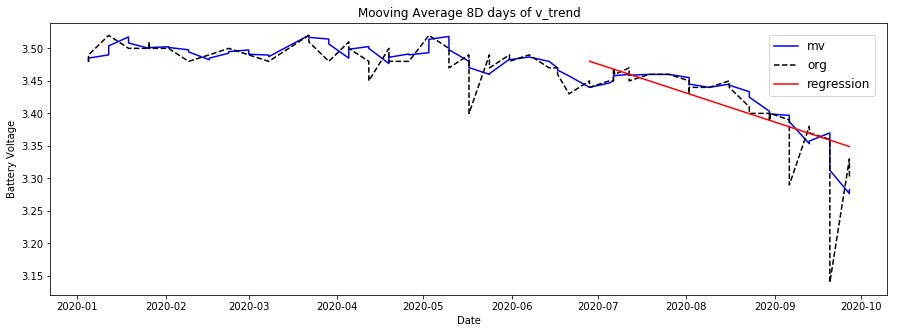

In [6]:
#移動平均から線形1次近似

#目的変数
#minpval = 3 #最低3つデータが必要
#v_trend_mv=v_trend["Battery"].rolling(mv,min_periods=minpval).mean().dropna().tail(mv0) #mv0個のデータで計算

#個数ではなく日数指定でデータ取り出し
term2 = datetime.timedelta(days=91)#最長約3ヶ月分
v_trend_mv=v_trend["Battery"].rolling(mv).mean()
v_trend_mv_term2=v_trend_mv[v_trend_mv.index.max()- term2 : v_trend_mv.index.max()]

#v_trend_mv=v_trend["Battery"].rolling(mv).mean() #全トレンドデータ考慮の場合

#説明変数
#x_mv=np.arange(len(v_trend_mv_term2)).reshape(-1, 1)
x_mv=v_trend_mv_term2.index.map(pd.Timestamp.timestamp) #日付をそのまま計算に使う。

#近似式の係数
#res_mv=np.polyfit(x_mv.reshape(-1), v_trend_mv_term2, 1) #1次
res_mv=np.polyfit(x_mv, v_trend_mv_term2, 1) #1次

#近似式の計算
y_mv = np.poly1d(res_mv)(x_mv)

#グラフ表示
plt.figure(figsize=(15, 5))

plt.subplot()
plt.plot(v_trend_mv.index, v_trend_mv, label="mv",color="b")

plt.plot(v_trend["Battery"],linestyle = "dashed", label="org",color="k")
plt.plot(v_trend_mv_term2.index, y_mv, label="regression",color="r")

plt.title("Mooving Average {} days of v_trend".format(mv))
plt.xlabel("Date")
plt.ylabel("Battery Voltage")
plt.legend(bbox_to_anchor=(1, 1), loc='upper right', borderaxespad=1, fontsize=12)

plt.show()
#savefig(prms, "Mooving Average of v_trend") #TR-BRAINに表示

In [7]:
#傾きが負で電圧が"v_lim"未満なら電圧降下と判定
v_lim=3.48
if res_mv[0] < 0 and v_trend_mv[v_trend.index.max()]<v_lim:
    print("電圧降下")
else:
    print("正常")
    

電圧降下
